### `JPEG Artifact Correction using Denoising Diffusion Restoration Models`

In [1]:
%cd /content/drive/MyDrive/dip_project
!git clone https://github.com/bahjat-kawar/ddrm-jpeg.git

/content/drive/MyDrive/dip_project
Cloning into 'ddrm-jpeg'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 90 (delta 7), reused 90 (delta 7), pack-reused 0
Unpacking objects: 100% (90/90), 643.10 KiB | 482.00 KiB/s, done.


### `Compression Artifacts Reduction by a Deep Convolutional Network`

In [1]:
## IMPORTS ##
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm
import random
import os

random.seed(42)


In [2]:
TRAIN_BASE = '/content/drive/MyDrive/dip_project/DIV2K_train_HR/DIV2K_train_HR'
VALID_BASE = '/content/drive/MyDrive/dip_project/DIV2K_valid_HR/DIV2K_valid_HR'

train_files = sorted(glob.glob(TRAIN_BASE + "/*.png"))
valid_files = sorted(glob.glob(VALID_BASE + "/*.png"))

In [3]:
class Args(object):
  def __init__(self):
    super(Args, self).__init__()
    self.ch_in=1
    self.ch_mid=64
    self.ch_out=32
    self.dilation_size = [1, 2, 4]

    self.optimizer = 'adam'
    self.img_size = 80
    self.batch_size = 10
    self.learning_rate = 1e-4

    self.train_path = '/content/drive/MyDrive/dip_project/DIV2K_train_HR/DIV2K_train_HR'
    self.valid_path = '/content/drive/MyDrive/dip_project/DIV2K_valid_HR/DIV2K_valid_HR'
    self.result_path = '/content/drive/MyDrive/dip_project'

    self.repeat = 16
    self.quality_level = [10, 20, 30]



#### `Dataset`

In [4]:
from PIL import Image
from io import BytesIO

def jpeg_encoding(img, quality_level):
  """ Processes the JPEG Encoding
  """
  output_buffer = BytesIO()
  img.save(output_buffer, format='JPEG', quality=quality_level)
  output_buffer.seek(0)
  encoded_img = Image.open(output_buffer)

  return encoded_img

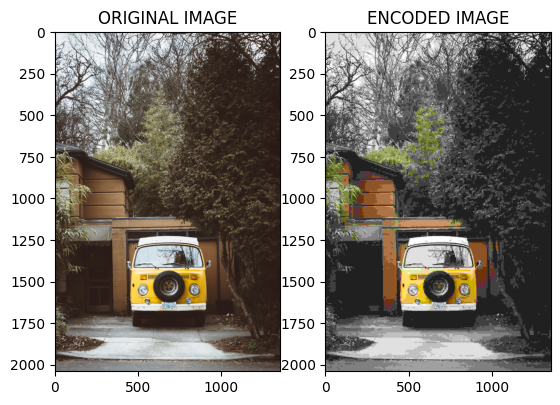

In [30]:
if __name__ == "__main__":
  idx = random.choice([int(i) for i in range(len(train_files))])
  img = Image.open(train_files[idx])
  encoded = jpeg_encoding(img, 1)
  plt.subplot(1, 2, 1);plt.title("ORIGINAL IMAGE");plt.imshow(img)
  plt.subplot(1, 2, 2);plt.title("ENCODED IMAGE");plt.imshow(encoded) ## 이렇게 JPEG으로 깨진 이미지가 있으면 여기서 patch 단위로 잘라서 확인해 보면 된다. 색상 측면에서 변화가 좀 있는 것으로 확인이 되고,
  ## 원래는 안보이던 artifact들을 확인할 수 있었다.

In [31]:
test = np.array(encoded.convert('YCbCr'))
print(test.shape)

(2040, 1356, 3)



YCrCb (also known as YCC or YUV) is a color space used in digital image and video processing. It represents colors by separating the image into three channels: Y (luma or brightness), Cr (chroma-red difference), and Cb (chroma-blue difference).

The Y channel carries the grayscale or brightness information of the image. It represents the intensity or luminance component, similar to a black and white image. The Y channel is primarily responsible for capturing the details and overall brightness of the image.

The Cr and Cb channels carry the color difference information. They represent the chrominance components and provide color information relative to the grayscale brightness represented by the Y channel. The Cr channel represents the red color difference, while the Cb channel represents the blue color difference. By combining the grayscale information from the Y channel with the color difference information from the Cr and Cb channels, the full color image can be reconstructed.

Separating the image into YCrCb channels allows for efficient compression and processing of color images. It takes advantage of the fact that the human visual system is more sensitive to changes in brightness (Y) compared to changes in color (Cr and Cb). This color space is commonly used in image and video compression standards like JPEG and MPEG.

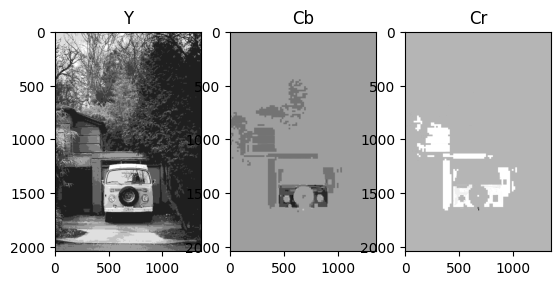

In [33]:
plt.subplot(1, 3, 1);plt.title("Y");plt.imshow(test[:, :, 0], cmap='gray')
plt.subplot(1, 3, 2);plt.title("Cb");plt.imshow(test[:, :, 1], cmap = 'gray')
plt.subplot(1, 3, 3);plt.title("Cr");plt.imshow(test[:, :, 2], cmap = 'gray')

In [5]:
class JPEGDataset(Dataset):
  def __init__(self, mode, args):
    super(JPEGDataset, self).__init__()
    self.mode = mode
    self.args = args
    self._set_paths()


  def _set_paths(self):
    if self.mode == 'train':
      self.files = sorted(glob.glob(self.args.train_path + "/*.png"))
    else:
      self.files = sorted(glob.glob(self.args.valid_path + "/*.png"))

  def _make_train_patch(self, img, quality_level):
    encoded_img = jpeg_encoding(img, quality_level)
    encoded_img = np.array(encoded_img.convert('YCbCr'))[:, :, 0] ## Y Channel만을 사용한다.
    H, W = encoded_img.shape

    patch_size = self.args.img_size
    h = np.random.choice(range(patch_size // 2, H - patch_size//2))
    w = np.random.choice(range(patch_size // 2, W - patch_size//2))
    patch = encoded_img[h-patch_size//2:h+patch_size//2, w-patch_size//2:w+patch_size//2]

    gt = np.array(img.convert('YCbCr'))[:, :, 0][h-patch_size//2:h+patch_size//2, w-patch_size//2:w+patch_size//2]

    return patch, gt

  def _make_test_patches(self, img, quality_level):
    encoded_img = jpeg_encoding(img, quality_level)
    encoded_img = np.array(encoded_img.convert('YCbCr'))[:, :, 0] ## Y Channel만을 사용한다.

    gt = np.array(img.convert('YCbCr'))[:, :, 0]

    return encoded_img, gt

  def __len__(self):
    if self.mode == 'train':
      return len(self.files) * self.args.repeat
    else:
      return len(self.files)

  def __getitem__(self, idx, quality_level=None):
    idx %= len(self.files)
    img = Image.open(self.files[idx])
    quality_level = random.choice(self.args.quality_level) if quality_level is None else quality_level
    if self.mode == 'train':
      patch, gt = self._make_train_patch(img, quality_level)
    else:
      patch, gt = self._make_test_patches(img, quality_level)

    aug = transforms.ToTensor()

    patch_tensor, gt_tensor = aug(patch), aug(gt)

    if self.mode == 'train':
      return patch_tensor, gt_tensor
    else:
      return patch_tensor, gt_tensor, self.files[idx]











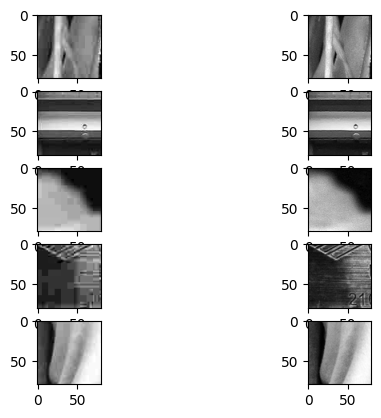

In [16]:
if __name__ == "__main__":
  train_dataset = JPEGDataset(mode='train', args =Args())
  train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=10)
  for idx, batch in enumerate(train_dataloader):
    input, gt = batch
    break
  for b in range(5):
    plt.subplot(5, 2, b*2+1);plt.imshow(input[b, 0, :, :], cmap='gray')
    plt.subplot(5, 2, b*2+2);plt.imshow(gt[b, 0, :, :], cmap = 'gray')

In [17]:
print(input.max(), input.min())

tensor(0.9961) tensor(0.)


#### `Model`

`1. Multi-Scale Feature Extraction`

In [6]:
class FeatureExtractor(nn.Module):
  def __init__(self, ch_in, ch_out, dilation_size=[1, 2, 4]):
    super(FeatureExtractor, self).__init__()
    self.dilated_conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=dilation_size[0], dilation=dilation_size[0], bias=True)
    self.dilated_conv2 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=dilation_size[1], dilation=dilation_size[1], bias=True)
    self.dilated_conv3 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=dilation_size[2], dilation=dilation_size[2], bias=True)

  def forward(self, x):
    x1 = self.dilated_conv1(x)
    x2 = self.dilated_conv2(x)
    x3 = self.dilated_conv3(x)
    # print(x1.shape,x2.shape, x3.shape)
    out = torch.cat([x1, x2, x3], dim=1)
    return out

In [7]:
if __name__ == "__main__":
  net = FeatureExtractor(1, 64)
  x = torch.rand((4, 1, 80, 80))
  out= net(x)
  print(f"Output of Feature Extractor : {out.shape}")

Output of Feature Extractor : torch.Size([4, 192, 80, 80])


`2. Convolutional LISTA`

In [8]:
class ConvLISTA(nn.Module):
  def __init__(self, ch_in, ch_out, n_layers=40):
    super(ConvLISTA, self).__init__()
    self.G_conv = nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=1), nn.ReLU(inplace=True)
    )
    S_conv = []
    for n in range(n_layers):
      S_conv.append(nn.Conv2d(ch_out, ch_out, kernel_size=3, padding=1, stride=1))
    self.S_conv = nn.ModuleList(S_conv)

  def forward(self, x):
    res = self.G_conv(x)
    for idx, layer in enumerate(self.S_conv):
      out = layer(res)
      res = out + res
      res = F.relu(res)
    return res

In [9]:
if __name__ == "__main__":
  net = ConvLISTA(64 * 3, 32)
  x = torch.rand((4, 192, 80, 80))
  out = net(x)
  print(f"Output of ConvLISTA : {out.shape}")

Output of ConvLISTA : torch.Size([4, 32, 80, 80])


`3. Image Reconstruction`

In [10]:
class Reconstructor(nn.Module):
  def __init__(self, ch_in, ch_out):
    super(Reconstructor, self).__init__()
    self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True)

  def forward(self, original_x, conv_x):
    out = self.conv(conv_x)
    out += original_x
    return out

In [11]:
if __name__ == "__main__":
  net = Reconstructor(32, 1)
  x = torch.rand((4, 32, 80, 80))
  org_x = torch.rand((4, 1, 80, 80))
  out = net(org_x, x)
  print(f"Output of Reconstructor : {out.shape}")

Output of Reconstructor : torch.Size([4, 1, 80, 80])


`4. Final DCSC Model`

In [12]:
class DCSC(nn.Module):
  def __init__(self, args):
    super(DCSC, self).__init__()
    self.feature_extractor = FeatureExtractor(args.ch_in, args.ch_mid, dilation_size=args.dilation_size)
    self.conv_lista = ConvLISTA(len(args.dilation_size) * args.ch_mid, args.ch_out, n_layers=40)
    self.reconstructor = Reconstructor(args.ch_out, 1)

  def forward(self, x):
    out = self.feature_extractor(x)
    out = self.conv_lista(out)
    out = self.reconstructor(x, out)
    return out

In [13]:
if __name__ == "__main__":
  net = DCSC(args = Args())
  x = torch.rand(4,1,80,80)
  out = net(x)
  print(f"Output of DCSC : {out.shape}")

Output of DCSC : torch.Size([4, 1, 80, 80])


#### `Training & Evaluating`

In [14]:
from skimage.metrics import peak_signal_noise_ratio
import cv2

def save_pred(pred, img_path, dir):
  img_n = os.path.basename(img_path[0])
  pred = pred.detach().cpu().numpy()
  pred = (pred - pred.min()) / (pred.max() - pred.min())
  pred *= 255.
  pred = pred[0, 0, :, :]
  cv2.imwrite(os.path.join(dir,img_n), pred)

def validate(model, valid_dataloader, device, args):
  print("Start Evaluating...")
  loop = tqdm.tqdm(valid_dataloader)
  dir = os.path.join(args.result_path, "dcsc_result", args.exp)
  os.makedirs(dir, exist_ok=True)
  psnr = 0.
  for idx, batch in enumerate(loop):
    input, target, img_path = batch
    input = input.to(device)
    target = target.to(device)

    pred = model(input)
    running_psnr = peak_signal_noise_ratio(target.detach().cpu().numpy(), pred.detach().cpu().numpy(), data_range=1.)

    psnr += running_psnr

    loop.set_postfix({"PSNR": running_psnr})
    save_pred(pred, img_path, dir)
    target.detach().cpu().numpy();pred.detach().cpu().numpy()
    ## 무조건 아래와 같이 del, empty_cache()를 사용해서 cuda memory를 비워줘야 한다. ##
    del target
    del pred
    torch.cuda.empty_cache()

  return psnr / len(valid_dataloader)

def train(model, train_dataloader, valid_dataloader, optimizer, criterion, device, args):
  print("Start Training...")
  total_epoch = args.epoch
  dir = os.path.join(args.result_path, "dcsc_weight", args.exp)
  os.makedirs(dir, exist_ok=True)

  best_psnr = 0.
  for epoch in range(total_epoch):
    if epoch % args.eval_epoch == 0:
      psnr = validate(model, valid_dataloader, device, args)
      if psnr > best_psnr:
        best_psnr = psnr
        torch.save(model.state_dict(), os.path.join(dir, "best.pth"))

    loop = tqdm.tqdm(train_dataloader, desc=f"Training epoch : {epoch+1} / {total_epoch}")
    for idx, batch in enumerate(loop):
      optimizer.zero_grad()
      input, target = batch
      input = input.to(device)
      target = target.to(device)

      pred = model(input)

      loss = criterion(pred, target)

      loss.backward()
      optimizer.step()

      loop.set_postfix({"Loss": loss.item()})
      del pred
      del input
      del target
      torch.cuda.empty_cache()


    torch.save(model.state_dict(), os.path.join(dir, "recent.pth"))







In [16]:
class Args(object):
  def __init__(self):
    super(Args, self).__init__()
    self.ch_in=1
    self.ch_mid=64
    self.ch_out=32
    self.dilation_size = [1, 2, 4]
    self.epoch = 10
    self.eval_epoch = 5

    self.optimizer = 'adam'
    self.img_size = 80
    self.batch_size = 10
    self.learning_rate = 1e-4

    self.train_path = '/content/drive/MyDrive/dip_project/DIV2K_train_HR/DIV2K_train_HR'
    self.valid_path = '/content/drive/MyDrive/dip_project/DIV2K_valid_HR/DIV2K_valid_HR'
    self.result_path = '/content/drive/MyDrive/dip_project'

    self.repeat = 16
    self.quality_level = [10, 20, 30]

    self.resume = True

    self.exp = 'dcsc_first_trial'

if __name__ == "__main__":
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  args = Args()
  result_path = args.result_path
  os.makedirs(os.path.join(result_path, "dcsc_result"), exist_ok=True)
  os.makedirs(os.path.join(result_path, "dcsc_weight"), exist_ok=True)

  train_dataset = JPEGDataset(mode='train', args=args)
  valid_dataset = JPEGDataset(mode='valid', args=args)

  train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args.batch_size)
  valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=1)

  model = DCSC(args).to(device)
  if args.resume == True:
    model.load_state_dict(torch.load(os.path.join(args.result_path, 'dcsc_weight', args.exp, 'best.pth')))

  optimizer = torch.optim.Adam(model.parameters(), args.learning_rate)
  criterion = nn.L1Loss()

  train(model, train_dataloader, valid_dataloader, optimizer, criterion, device, args)





Start Training...
Start Evaluating...


Training epoch : 5 / 10: 100%|██████████| 1280/1280 [49:59<00:00,  2.34s/it, Loss=0.0143]


Start Evaluating...


Training epoch : 10 / 10: 100%|██████████| 1280/1280 [50:01<00:00,  2.34s/it, Loss=0.0226]
